## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 2]

combined_group_one = pd.concat([group_one, group_two], ignore_index = True)
combined_group_one["Diagnosis"].unique()

array([0, 2])

In [4]:
combined_group_one

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,549,0,68.8849,2,25.0,0.11,169.76,0.58,205.91,38.90,...,219.32,0.53,229.07,30.38,696.95,3.05,1.54,3.53,2140.0,3801.0
274,658,0,72.2822,2,30.0,0.13,187.66,0.57,222.54,37.58,...,206.16,0.55,227.90,30.10,705.46,3.03,281.47,NaN,2750.0,3345.0
275,1244,0,79.0877,2,24.0,0.13,152.52,0.63,208.54,35.72,...,220.67,0.53,231.71,30.18,706.18,3.02,28.95,2.98,2016.0,3532.0
276,1311,0,69.2110,2,29.0,0.10,175.27,0.50,187.40,44.04,...,222.69,0.52,229.54,32.03,695.47,3.05,2811.38,2.98,1605.0,3219.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_one.drop("Diagnosis", axis=1),  
    combined_group_one["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [6]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [8]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [9]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [10]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((194, 23), (84, 23))

In [11]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr', threshold=0.0005)

In [12]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.9296777296777297)

In [13]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'Gender': np.float64(0.008938592271925616),
 'ERCsASMbaseline': np.float64(0.002533269199935795),
 'ERCsSumAveragebaseline': np.float64(0.002437069103735867),
 'ERCsVariancebaseline': np.float64(0.0044492544492544805),
 'ERCsEntropybaseline': np.float64(0.0044091710758376035),
 'ERCsCorelationbaseline': np.float64(0.0005531505531504166),
 'HipsASMbaseline': np.float64(0.0031184864518196687),
 'HipsContrastbaseline': np.float64(-0.0014991181657848518),
 'ERCsContrastbaseline': np.float64(-0.0013307679974348119),
 'HipsSumVariancebaseline': np.float64(0.002645502645502784),
 'HipsClusterShadebaseline': np.float64(-0.0006413339746671465),
 'HipsCorelationbaseline': np.float64(5.611672278327262e-05),
 'HipsEntropybaseline': np.float64(0.002068302068302108),
 'HipsVariancebaseline': np.float64(0.0045775212441879765),
 'HipsSumAveragebaseline': np.float64(-0.0024691358024689913),
 'ERCsClusterShadebaseline': np.float64(-0.0036315536315537633),
 'ERCsSumVariancebaseline': np.float64(0.001266

In [14]:
sel.feature_importances_

Gender                        0.000276
ERCsASMbaseline               0.000313
ERCsSumAveragebaseline        0.000715
ERCsVariancebaseline          0.000765
ERCsEntropybaseline           0.001958
ERCsCorelationbaseline        0.002036
HipsASMbaseline               0.002062
HipsContrastbaseline          0.005781
ERCsContrastbaseline          0.007675
HipsSumVariancebaseline       0.008878
HipsClusterShadebaseline      0.011731
HipsCorelationbaseline        0.013517
HipsEntropybaseline           0.015970
HipsVariancebaseline          0.016539
HipsSumAveragebaseline        0.017580
ERCsClusterShadebaseline      0.026648
ERCsSumVariancebaseline       0.033583
ERCs_thicknessbaseline        0.037703
Ageatscreening                0.040563
RID                           0.069052
ERCsVolumebaseline            0.090175
HipposcampusVolumebaseline    0.129995
MMSE0m                        0.466484
dtype: float64

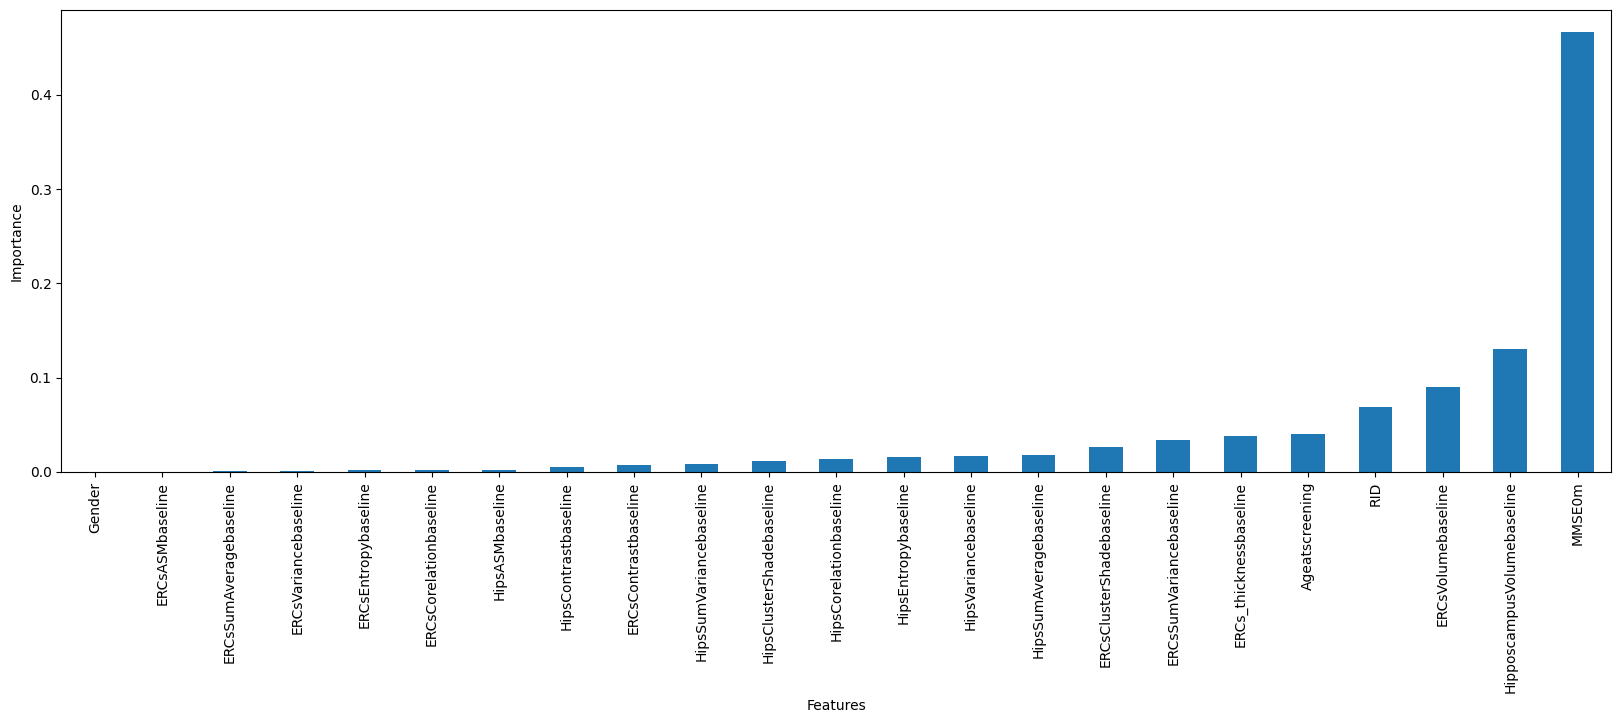

In [15]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

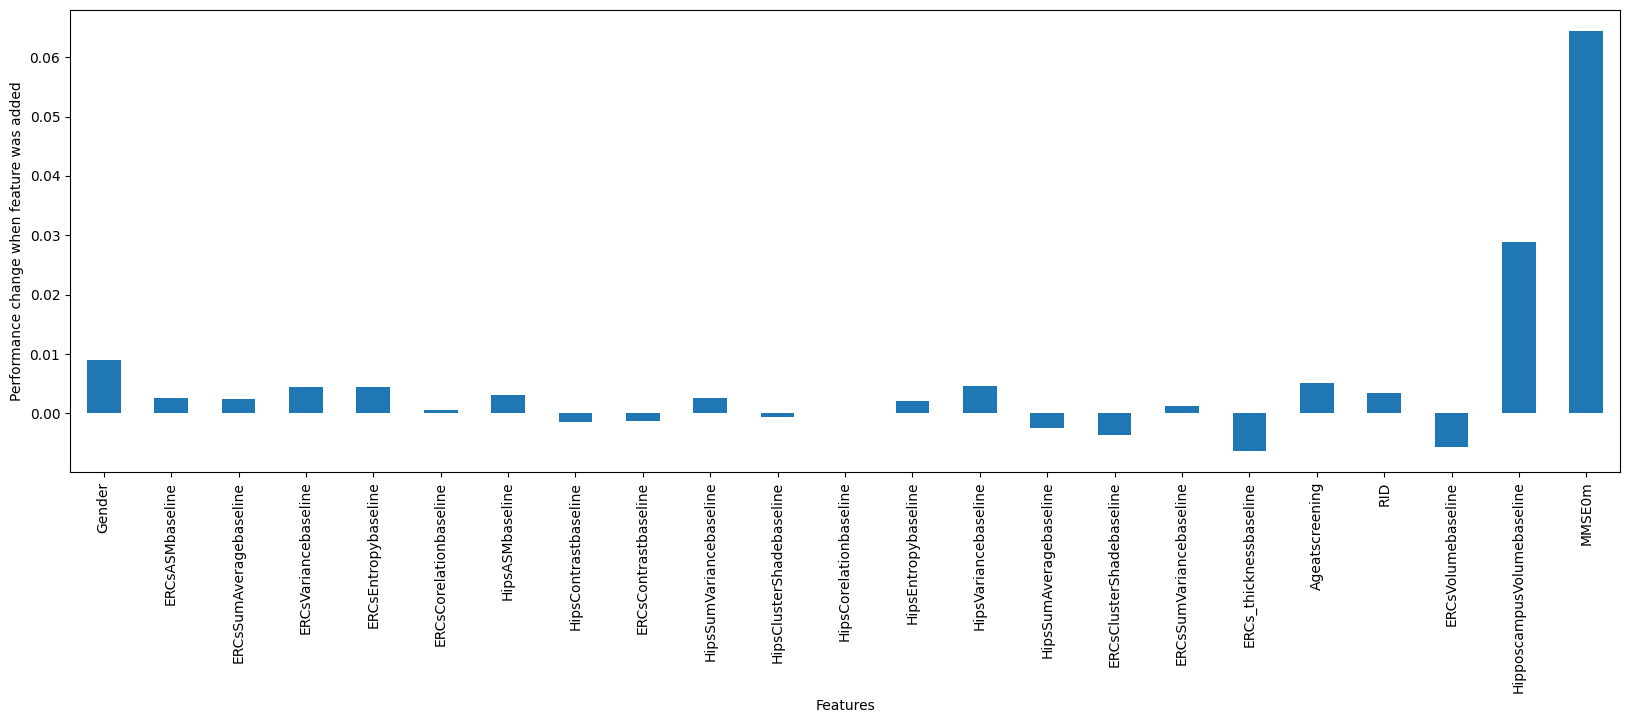

In [16]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [17]:
# Number of features that will be removed

sel.features_to_drop_

['HipsContrastbaseline',
 'HipsCorelationbaseline',
 'HipsSumAveragebaseline',
 'HipsClusterShadebaseline',
 'ERCsContrastbaseline',
 'ERCsClusterShadebaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline']

In [18]:
# select features
X_train_t = sel.transform(X_train_knn_t)
X_test_t = sel.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((194, 15), (84, 15))

## Classification Test

In [19]:
from ngboost.distns import Bernoulli
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss",
                                use_label_encoder=False,
                                objective="binary:logistic",
                                verbosity=0)
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(2),
                                      n_estimators=100,
                                      verbose=False) 
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [20]:
from sklearn.preprocessing import LabelEncoder

# 1) Fit a label encoder on the training labels:
le_train = LabelEncoder().fit(y_train)
le_test = LabelEncoder().fit(y_test)

# 2) Transform y_train (and later y_test) to {0,1} internally:
y_train_enc = le_train.transform(y_train)
y_test_enc = le_test.transform(y_test)

In [21]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train_enc)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train_enc)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train_enc)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train_enc)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train_enc)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train_enc)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train_enc)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train_enc)

In [22]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Fit Time Total Features Metric                          
Boruta            Random Forest       0.293    23             balanced_accuracy       0.988   
                                      0.235    15             balanced_accuracy       0.984   
                  XGBoost             0.140    23             balanced_accuracy       1.000   
                                      0.092    15             balanced_accuracy       1.000   
                  NGBoost             0.493    23             balanced_accuracy       0.941   
                                      0.463    15             balanced_accuracy       0.946   
                  Logistic Regression 0.006    23             balanced_accuracy       0.928   
                                      0.005    15             balanced_accuracy       0.920   

                                                                                 Std Train  \
Feature Selection Classifier          Fit Time Total Features Metric                         
Boruta            Random Forest       0.293    23             balanced_accuracy      0.005   
                                      0.235    15             balanced_accuracy      0.005   
                  XGBoost             0.140    23             balanced_accuracy      0.000   
                                      0.092    15             balanced_accuracy      0.000   
                  NGBoost             0.493    23             balanced_accuracy      0.009   
                                      0.463    15             balanced_accuracy      0.005   
                  Logistic Regression 0.006    23             balanced_accuracy      0.006   
                                      0.005    15             balanced_accuracy      0.007   

                                                                                 Mean Test  \
Feature Selection Classifier          Fit Time Total Features Metric                         
Boruta            Random Forest       0.293    23             balanced_accuracy      0.847   
                                      0.235    15             balanced_accuracy      0.849   
                  XGBoost             0.140    23             balanced_accuracy      0.864   
                                      0.092    15             balanced_accuracy      0.873   
                  NGBoost             0.493    23             balanced_accuracy      0.833   
                                      0.463    15             balanced_accuracy      0.810   
                  Logistic Regression 0.006    23             balanced_accuracy      0.902   
                                      0.005    15             balanced_accuracy      0.904   

                                                                                 Std Test  
Feature Selection Classifier          Fit Time Total Features Metric                       
Boruta            Random Forest       0.293    23             balanced_accuracy     0.082  
                                      0.235    15             balanced_accuracy     0.092  
                  XGBoost             0.140    23             balanced_accuracy     0.044  
                                      0.092    15             balanced_accuracy     0.068  
                  NGBoost             0.493    23             balanced_accuracy     0.093  
                                      0.463    15             balanced_accuracy     0.074  
                  Logistic Regression 0.006    23             balanced_accuracy     0.059  
                                      0.005    15             balanced_accuracy     0.060

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
                
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="binary"), 3),
                "recall": round(recall_score(y_train, pred_train, average="binary"), 3),
                "f1": round(f1_score(y_train, pred_train, average="binary"), 3),
                "roc_auc_ovr": round(roc_auc_score(y_train, pred_train_proba[:, 1]),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="binary"), 3),
                "recall": round(recall_score(y_test, pred_test, average="binary"), 3),
                "f1": round(f1_score(y_test, pred_test, average="binary"), 3),
                "roc_auc_ovr": round(roc_auc_score(y_test, pred_test_proba[:, 1]),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RFE",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train_enc, y_test_enc)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train_enc, y_test_enc)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train_enc, y_test_enc)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train_enc, y_test_enc)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
RFE               Random Forest       0.137               23             accuracy                0.990   
                                                                         balanced_accuracy       0.982   
                                                                         precision               1.000   
                                                                         recall                  0.965   
                                                                         f1                      0.982   
                                                                         roc_auc_ovr             1.000   
                                      0.155               15             accuracy                0.990   
                                                                         balanced_accuracy       0.982   
                                                                         precision               1.000   
                                                                         recall                  0.965   
                                                                         f1                      0.982   
                                                                         roc_auc_ovr             0.999   
                  XGBoost             0.135               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                                      0.121               15             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                  NGBoost             0.259               23             accuracy                0.964   
                                                                         balanced_accuracy       0.939   
                                                                         precision               1.000   
                                                                         recall                  0.877   
                                                                         f1                      0.935   
                                                                         roc_auc_ovr             0.999   
                                      0.156               15             accuracy                0.969   
                                                                         balanced_accuracy       0.947   
                                                                         precision               1.000   
                                                                         recall                  0.895   
                                                                         f1                      0.944   
                                                                         roc_auc_ovr             0.996   
                  Logistic Regression 0.039               23    